Valores nulos por columna:
 True_index             0
Store_ID               0
Day_of_week            0
Date                   0
Nb_customers_on_day    0
Open                   0
Promotion              0
State_holiday          0
School_holiday         0
Sales                  0
Year                   0
Month                  0
Day                    0
Week                   0
dtype: int64
🔍 R^2 en test: 0.85
🔍 RMSE en test: 1215.05


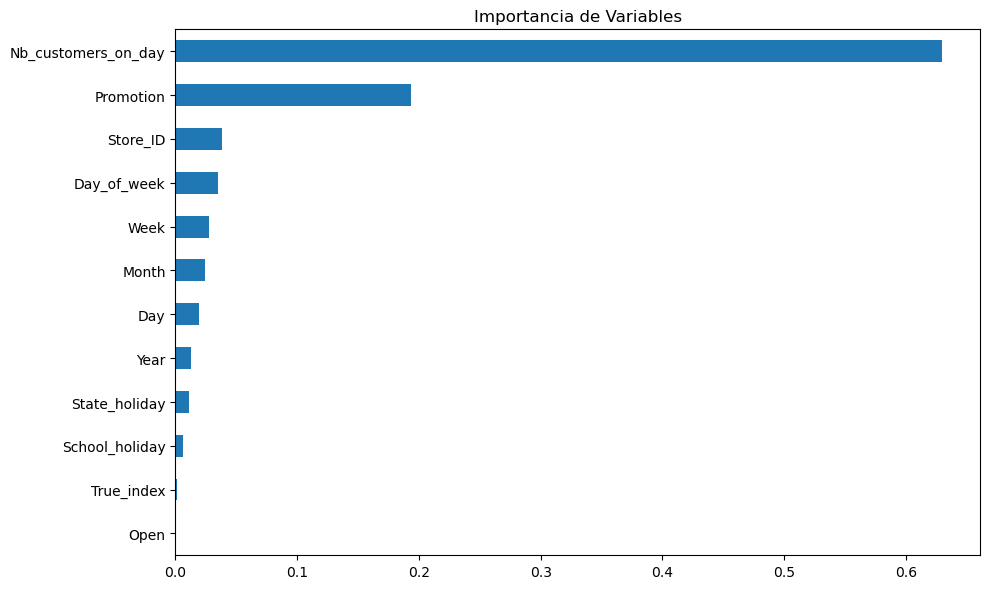

✅ Modelo guardado como sales_model.pkl


In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# 1. Cargar los datos
# url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv"
url = "data/1_sales.csv"
df = pd.read_csv(url)

# 2. Renombrar columnas si es necesario (según el ejemplo dado)
df.columns = ['True_index', 'Store_ID', 'Day_of_week', 'Date', 'Nb_customers_on_day',
              'Open', 'Promotion', 'State_holiday', 'School_holiday', 'Sales']


# 3. Convertir fecha a datetime y extraer componentes
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].dt.isocalendar().week

# 4. Revisar valores nulos
print("Valores nulos por columna:\n", df.isnull().sum())

# 5. Transformar columnas categóricas
df['State_holiday'] = df['State_holiday'].astype(str)  # asegurar que no es numérica
le = LabelEncoder()
df['State_holiday'] = le.fit_transform(df['State_holiday'])

# 6. Eliminar fechas y otras columnas si no aportan
df.drop(['Date'], axis=1, inplace=True)

# 7. Filtrar si está cerrado (opcional, ventas serán 0 si está cerrado)
df = df[df['Open'] == 1]

# 8. Separar variables predictoras y target
X = df.drop(['Sales'], axis=1)
y = df['Sales']

# 9. Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Entrenar un modelo (ej: XGBoost)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 11. Evaluar
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rsquared = model.score(X_test, y_test)
print(f"🔍 R^2 en test: {rsquared:.2f}")
print(f"🔍 RMSE en test: {rmse:.2f}")

# 12. Importancia de características
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', figsize=(10,6), title='Importancia de Variables')
plt.tight_layout()
plt.show()

# 13. Guardar el modelo
joblib.dump(model, "src/sales_model.pkl")
print("✅ Modelo guardado como sales_model.pkl")



## At 16:00, a new dataset (without target variable) will be revealed, and you’ll use your model to predict sales

In [51]:
# Cargar el test dataset: https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv
test_df = pd.read_csv("data/2_sales_notarget_test_16h.csv")  # o URL si lo tienes en línea

# Asegurar columna 'True_index'
if 'True_index' not in test_df.columns:
    test_df['True_index'] = 0

# Procesamiento como antes
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df['Week'] = test_df['Date'].dt.isocalendar().week

test_df['State_holiday'] = test_df['State_holiday'].astype(str)
le = LabelEncoder()
test_df['State_holiday'] = le.fit_transform(test_df['State_holiday'])

test_df.drop(columns=['Date'], inplace=True)

# Usar mismo orden de features del entrenamiento
trained_features = ['True_index', 'Store_ID', 'Day_of_week', 'Nb_customers_on_day', 'Open',
                    'Promotion', 'State_holiday', 'School_holiday', 'Year', 'Month', 'Day', 'Week']

X_test_final = test_df[trained_features]

# Predecir con el modelo entrenado
y_pred_test = model.predict(X_test_final)

# Guardar o visualizar resultados
test_df['Predicted_Sales'] = y_pred_test
print(test_df[['Store_ID', 'Nb_customers_on_day', 'Predicted_Sales']].head())

# Exportar si lo deseas
# test_df[['Store_ID', 'Predicted_Sales']].to_csv('3_sales_predictions.csv', index=False)

# Añadimos la columna 'True_index' para mantener la referencia y poder comparar con la solución
test_df[['True_index', 'Store_ID', 'Predicted_Sales']].to_csv('data/3_sales_predictions.csv', index=False)


   Store_ID  Nb_customers_on_day  Predicted_Sales
0       764                    0       754.253906
1        22                  449      4269.780762
2      1087                  622      6061.573730
3       139                  314      2969.304688
4       568                  356      3210.064697


## By 17:00, predictions for the new dataset must be delivered, for you LT/TA to compare your predictions with the real label Solutions

📊 Evaluación del modelo:
✅ R² score: 0.9458
📉 RMSE: 868.67
🧮 MAE:  629.67


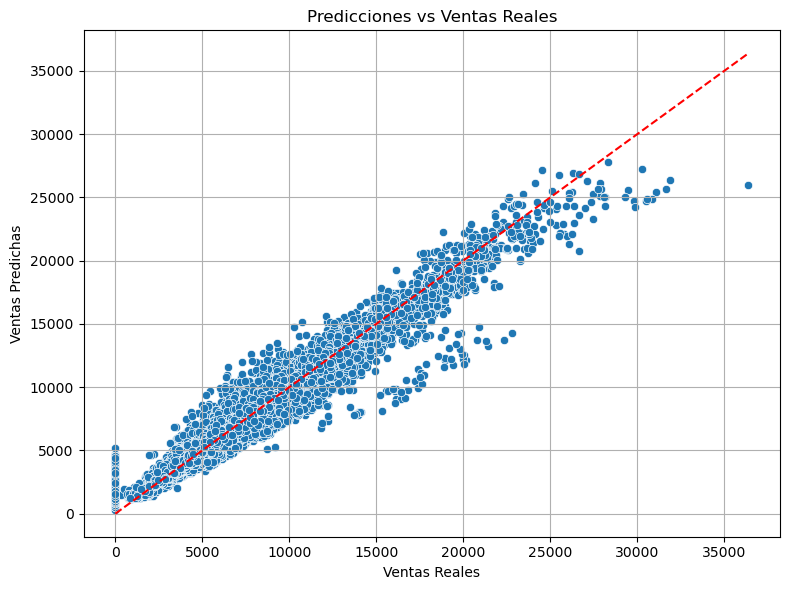

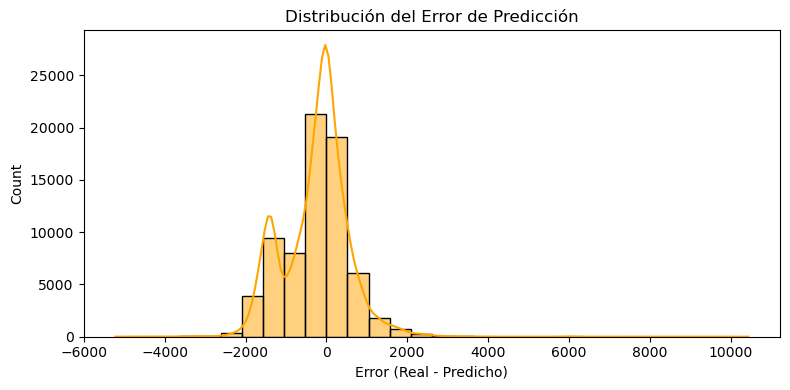

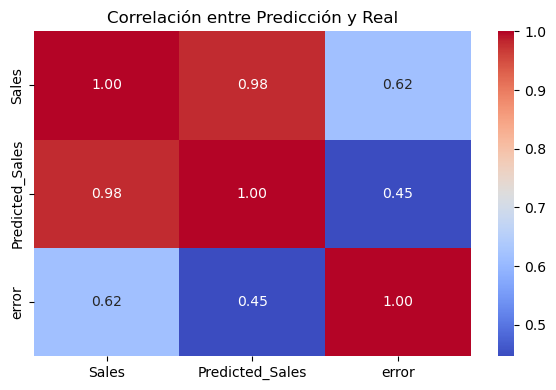

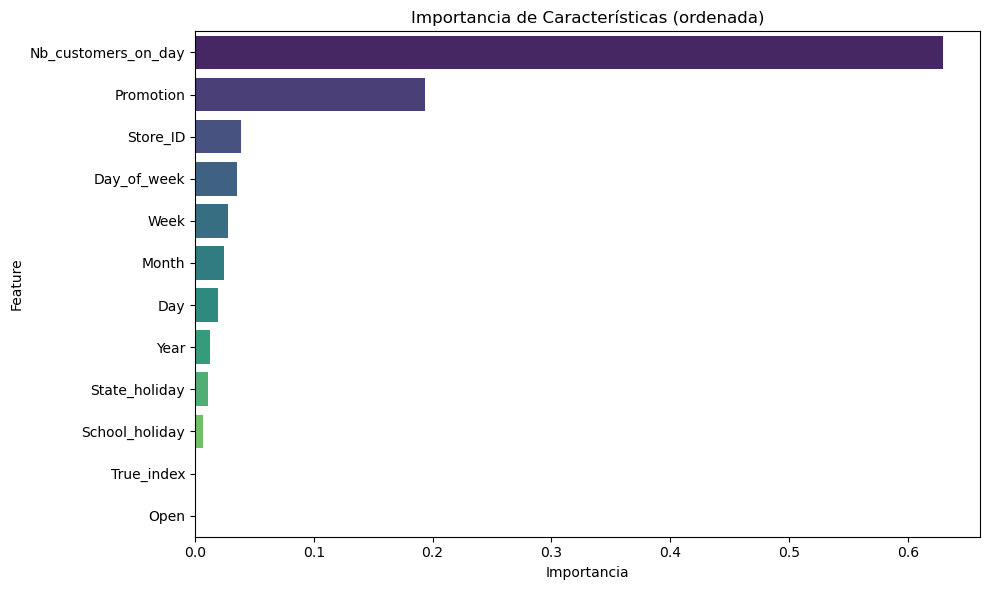

In [52]:
# 1. Cargar predicciones generadas previamente
pred_df = pd.read_csv("data/3_sales_predictions.csv")  # Debe tener: True_index, Predicted_Sales

# Opción 2 para comparar dataframes: Si ambos CSV están en el mismo orden de filas, puedes añadir un índice explícito (como True_index) al de predicciones.
# Antes de hacer merge, añadir índice explícito al CSV de predicciones
# pred_df.reset_index(inplace=True)
# pred_df.rename(columns={"index": "True_index"}, inplace=True)

# 2. Cargar ventas reales proporcionadas: https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_solutions.csv
real_df = pd.read_csv("data/4_sales_real_solutions.csv")  # Debe tener: True_index, Sales

# 3. Unir ambos dataframes por True_index
df = pd.merge(pred_df, real_df, on="True_index", how="inner")

# 4. Calcular métricas
r2 = r2_score(df['Sales'], df['Predicted_Sales'])
rmse = np.sqrt(mean_squared_error(df['Sales'], df['Predicted_Sales']))
mae = mean_absolute_error(df['Sales'], df['Predicted_Sales'])

print("📊 Evaluación del modelo:")
print(f"✅ R² score: {r2:.4f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"🧮 MAE:  {mae:.2f}")

# 5. Gráfica: Predicciones vs Reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Sales', y='Predicted_Sales', data=df)
plt.plot([df['Sales'].min(), df['Sales'].max()], [df['Sales'].min(), df['Sales'].max()], 'r--')
plt.xlabel("Ventas Reales")
plt.ylabel("Ventas Predichas")
plt.title("Predicciones vs Ventas Reales")
plt.grid(True)
plt.tight_layout()
plt.savefig("img/scatter_real_vs_pred.jpg")
plt.show()

# 6. Histograma del error
df['error'] = df['Sales'] - df['Predicted_Sales']
plt.figure(figsize=(8, 4))
sns.histplot(df['error'], kde=True, bins=30, color="orange")
plt.title("Distribución del Error de Predicción")
plt.xlabel("Error (Real - Predicho)")
plt.tight_layout()
plt.savefig("img/histogram_error.jpg")
plt.show()

# 7. Heatmap de correlación (entre predicciones y reales)
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Sales', 'Predicted_Sales', 'error']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre Predicción y Real")
plt.tight_layout()
plt.savefig("img/heatmap_correlation.jpg")
plt.show()

# 8. (Opcional) Importancia de características si tienes el modelo guardado
try:
    # ... después de cargar el modelo:
    if os.path.exists("src/sales_model.pkl"):
        model = joblib.load("src/sales_model.pkl")
        importances = model.feature_importances_
        feature_names = model.get_booster().feature_names

        # Crear DataFrame ordenado por importancia
        feat_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)  

        # Graficar barras horizontales ordenadas
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis', hue='Feature')
        plt.title("Importancia de Características (ordenada)")
        plt.xlabel("Importancia")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig("img/feature_importance.jpg")
        plt.show()
    else:
        print("ℹ️ Modelo no encontrado: salta importancia de features.")

except Exception as e:
    print("⚠️ No se pudo cargar el modelo para mostrar importancia de features:", e)
